# Fitting for lattice constant

Lattice constant from a 2D scan.

The notebook makes use of some standard python module as well as the `shem_spot_profile` module available on [Github](https://github.com/slambrick/SHeM-diffraction-analysis). The notebook supports the publication "Defect density quantification in monolayer MoS<sub>2</sub> using helium atom micro-diffraction".

In [17]:
import numpy as np
import SHeM_diffraction_analysis.shem_spot_profile as ssp
import matplotlib.pyplot as plt
from scipy import optimize

## Import data

Data stored in a series of individual zscan files.

(<Figure size 800x600 with 3 Axes>,
 <PolarAxes: xlabel='$\\alpha$'>,
 <Axes: ylabel='$\\log_{10}(I/\\mathrm{nA})$'>)

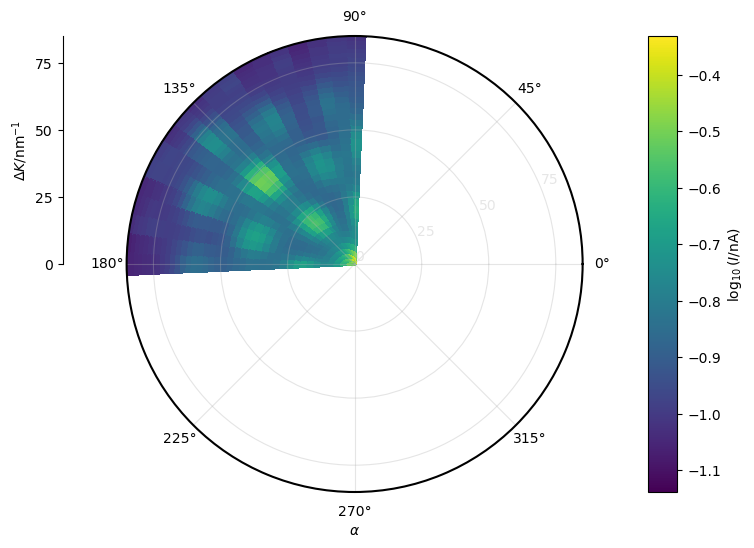

In [18]:
path_name='data/2023_12_defect1_repeat_5um_hbn_sub'

file_ind=[133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151]#,152,153]
angles = np.linspace(70,425,72)

z_zero = [1.2e6]
z_zero=np.linspace(1.08, 1.32, 19)*1e6
d1 = ssp.SpotProfile.import_ashem(file_ind, path_name, z_zero = z_zero, alphas=angles)#, assign_alphas=False)

# Background (SiO2) signal for normalising the signal
d1.shem_diffraction_plot()

## Functions for fitting

We fit a 2D Gaussian to the data, the Gaussian is allowed to rotate and have different standard deviations along its two axes,
$$
G(x, y) = A \cdot \mathrm{e}^{- \left[ a(x - x_0)^2 + 2b(x - x_0)(y - y_0) + c(y - y_0)^2 \right]}
$$
The coefficients $a$, $b$, and $c$ are defined so as to allow rotation:
$$
a = \frac{\cos^2\theta}{2\sigma_x^2} + \frac{\sin^2\theta}{2\sigma_y^2}
$$

$$
b = -\frac{\sin(2\theta)}{4\sigma_x^2} + \frac{\sin(2\theta)}{4\sigma_y^2}
$$

$$
c = \frac{\sin^2\theta}{2\sigma_x^2} + \frac{\cos^2\theta}{2\sigma_y^2}
$$
we also allow for a polynomial background, up to 2nd order:
$$
\text{background}(x,y) = f + gx + h7 + kxy + lx^2 + my^2
$$

In [19]:
def twoD_Gaussian(xy, amplitude, xo, yo, sigma_x, sigma_y, theta, f, g, h, k, l, m):
    '''Two dimensional gaussian for fitting.'''
    
    x, y = xy
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    tot = amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    #f, g, h, k, l, m = offset
    tot = tot + f + g*x + h*y + k*x*y + l*x**2 + m*y**2
    return tot.ravel()

def background(xy, f, g, h, k, l, m):
    x, y = xy
    tot = f + g*x + h*y + k*x*y + l*x**2 + m*y**2

def find_diff_peak(dataset, kx, ky, plotit=False, i=np.nan, size=8, method='nearest'):
    """Try to fit a 2D gaussian to the diffraction peak"""
    
    # The grid to be used for fitting, we isolate a single peak
    # to make the fitting easier
    I, kxx, kyy = dataset.grid_interpolate(kx = (kx-size, kx+size), 
                                            ky = (ky-size, ky+size), 
                                            N=101, method=method)
    if plotit:
        f, axs = plt.subplots(2, 2, figsize=(10, 10))
        ax1, ax2 = axs[0]
        ax3, ax4 = axs[1]
        # Identify a single diffraction peak
        axs[0,0].pcolormesh(kxx, kyy, I)
        #dataset.interpolated_plot(kx = (kx-size, kx+size), ky = (ky-size, ky+size), N = 101, 
        #                          method = method, ax=axs[0,0])
    # Initial guess for the height is the range
    height = np.max(I) - np.min(I)
    # Initial guess for the offset is the minimum
    offset = np.min(I)
    # Initial guess for the standard deviations is 3x3
    # Initial guess for the orinentation is 45deg (this is the most
    # dodgy one)
    initial_guess = (height,kx,ky,4,4,-45*np.pi/180, offset, 0, 0, 0, 0, 0)
    print('{},{}'.format(kx, ky))
    popt, pcov = optimize.curve_fit(twoD_Gaussian, (kxx, kyy), 
                                    I.flatten(), p0=initial_guess)

    if plotit:
        # Add the initial guess to the plot of the raw data
        axs[0,0].plot(kx, ky, 'bo')
        # Add the identified centre to the plot of the raw data
        axs[0,0].plot(popt[1], popt[2], 'ro')

        # Plot the fitted Gaussian (does it look decent at all?)
        Gau = twoD_Gaussian((kxx, kyy), popt[0], popt[1], popt[2], popt[3], popt[4], popt[5], 0, 0, 0, 0, 0, 0)
        axs[1,0].pcolormesh(kxx, kyy, Gau.reshape(101, 101), edgecolors='face')
        axs[1,0].axis('equal')
        axs[1,0].set_xlabel('$k_x/\\mathrm{nm}^{-1}$')
        axs[1,0].set_ylabel('$k_y/\\mathrm{nm}^{-1}$')
        axs[1,0].set_title('Fitted Gaussian')

        # Plot the background (does it look decent at all?)
        Back = ssp.background((kxx, kyy), popt[6], popt[7], popt[8], popt[9], popt[10], popt[11])
        axs[1,1].pcolormesh(kxx, kyy, Back.reshape(101, 101), edgecolors='face')
        axs[1,1].axis('equal')
        axs[1,1].set_xlabel('$k_x/\\mathrm{nm}^{-1}$')
        axs[1,1].set_ylabel('$k_y/\\mathrm{nm}^{-1}$')
        axs[1,1].set_title('Fitted Polynomial Background')

        # Plot the background (does it look decent at all?)
        GauTot = twoD_Gaussian((kxx, kyy), *popt)
        axs[0,1].pcolormesh(kxx, kyy, GauTot.reshape(101, 101), edgecolors='face')
        axs[0,1].axis('equal')
        axs[0,1].set_xlabel('$k_x/\\mathrm{nm}^{-1}$')
        axs[0,1].set_ylabel('$k_y/\\mathrm{nm}^{-1}$')
        axs[0,1].set_title('Total fit')
        #plt.savefig('all_fits/peak_fitted{:03d}.png'.format(i))
    return(popt)

## Perform fitting

Create initial guesses for the peak centres, then loop over each diffraction peak and perform the fitting.

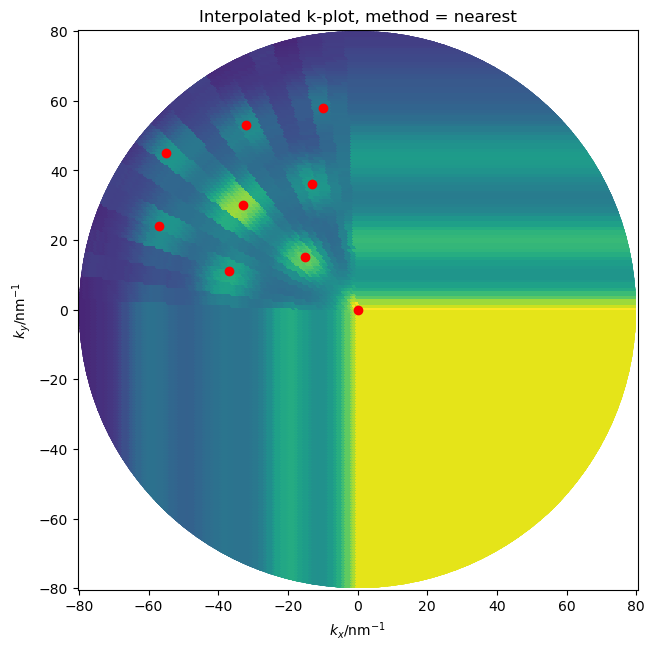

In [20]:
guess_peak = np.array([
    [-55,45],[-32,53],[-10,58],
    [-57,24],[-33,30],[-13,36],
    [-37,11],[-15,15],[0,0]
])

_, ax1, _  = d1.interpolated_plot(N=201,method='nearest')
for ks in guess_peak:
    ax1.plot(ks[0],ks[1],'ro')

If you want to see the plot of each fit then you can set the parameter
```python
plotit=True
```

-55,45
-32,53
-10,58
-57,24
-33,30
-13,36
-37,11
-15,15


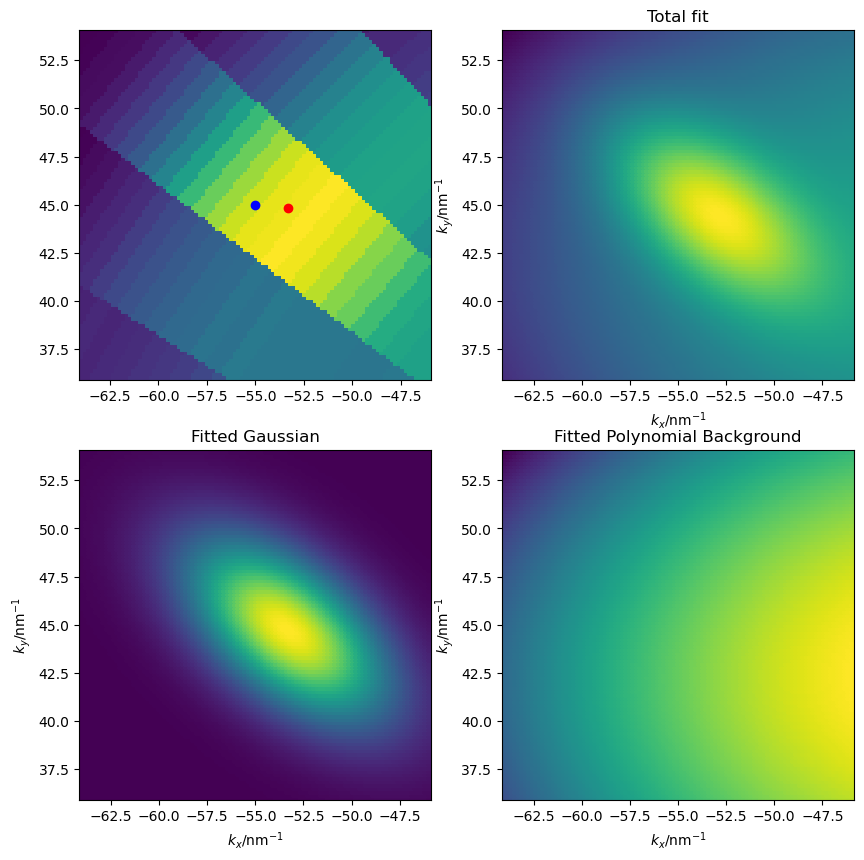

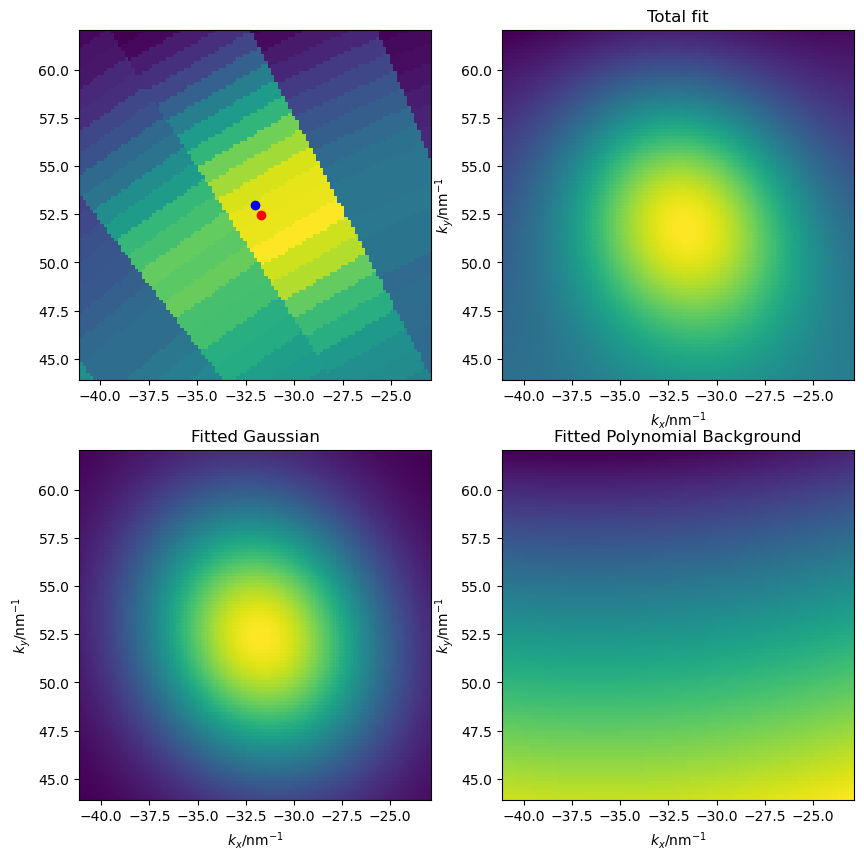

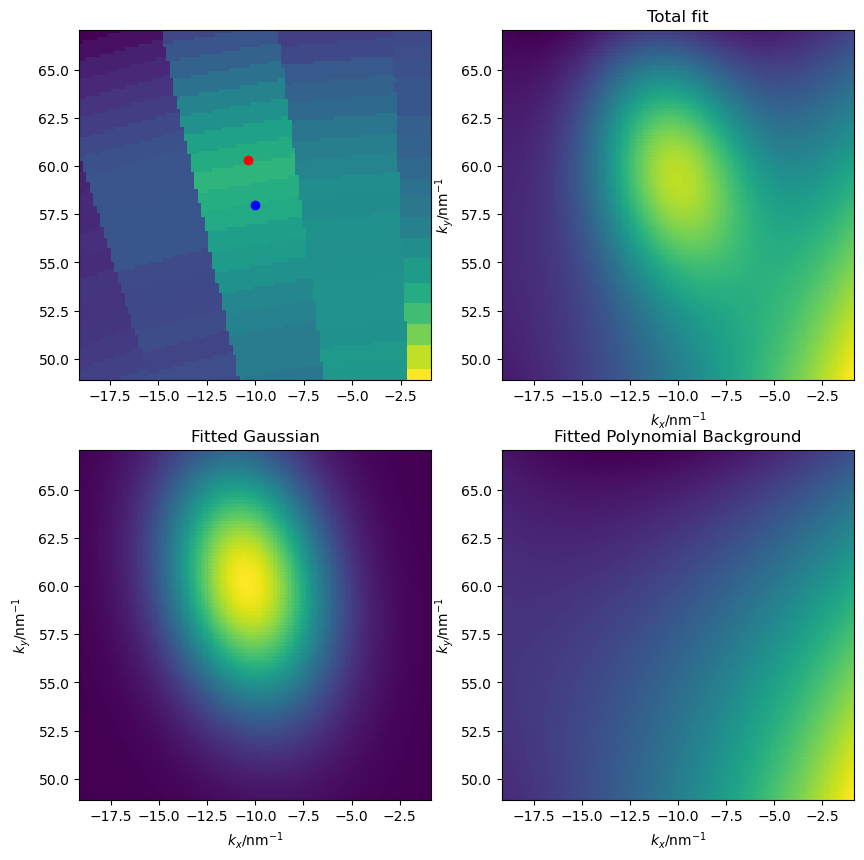

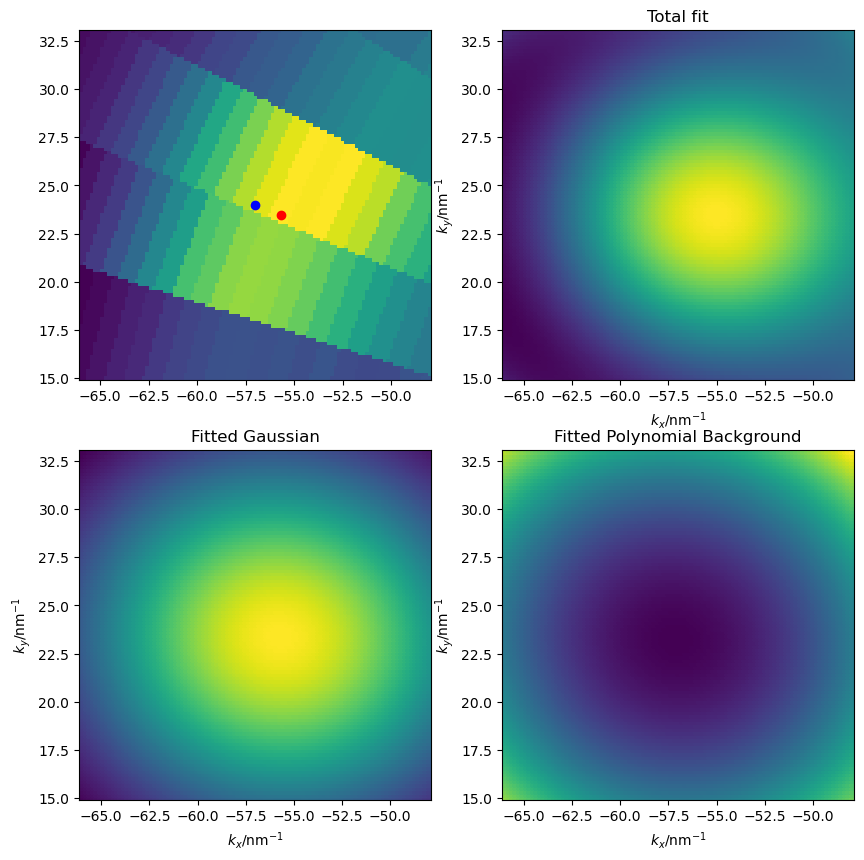

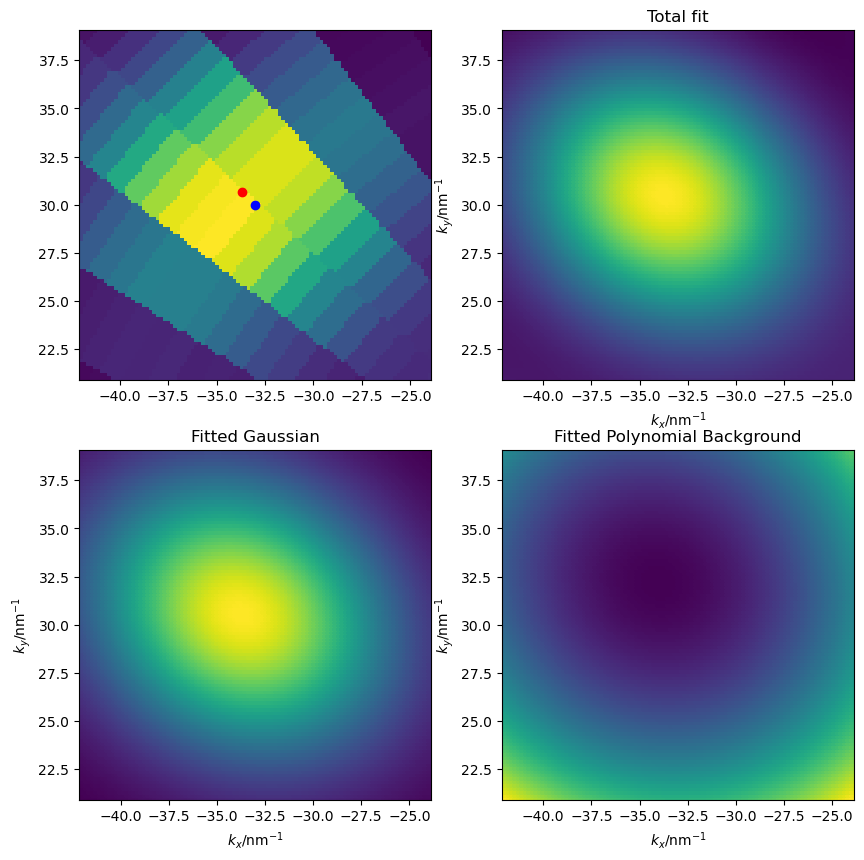

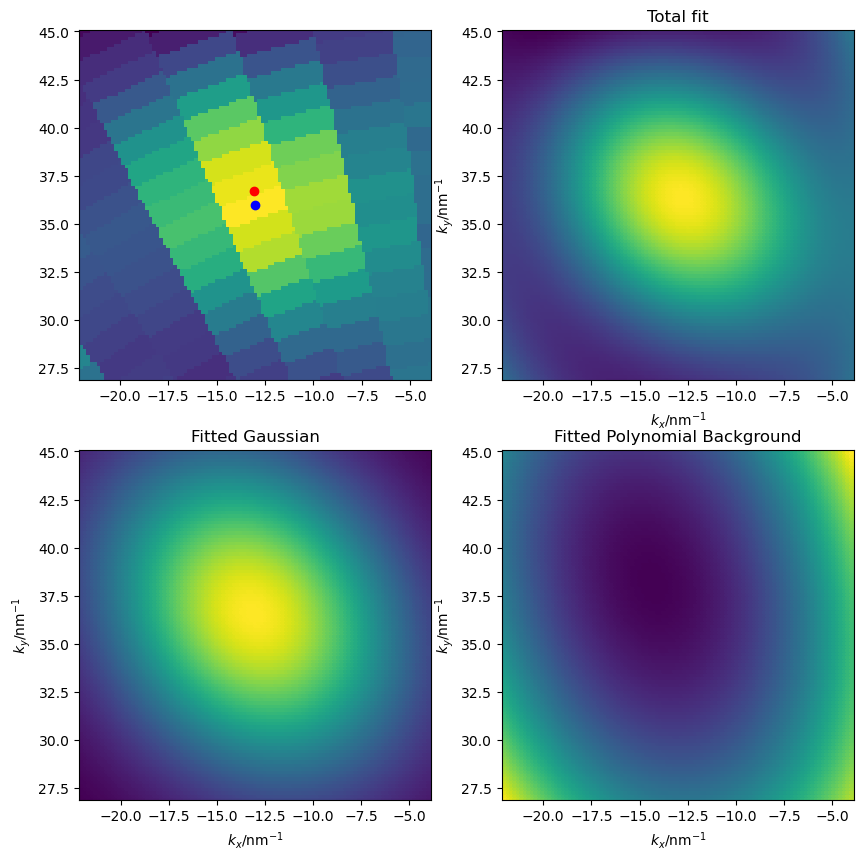

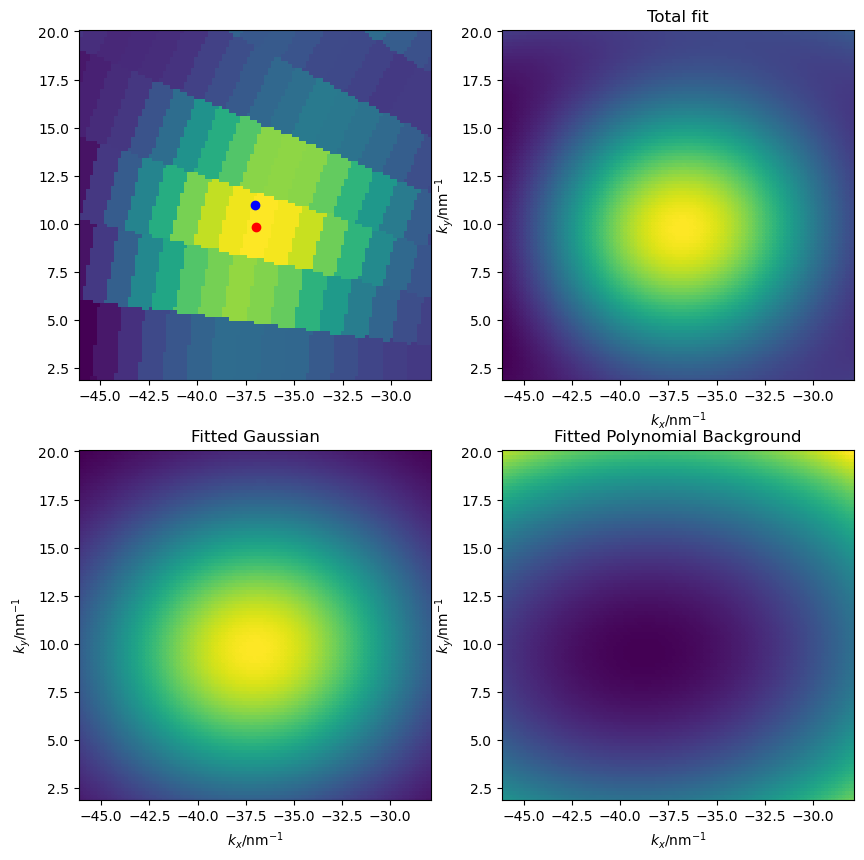

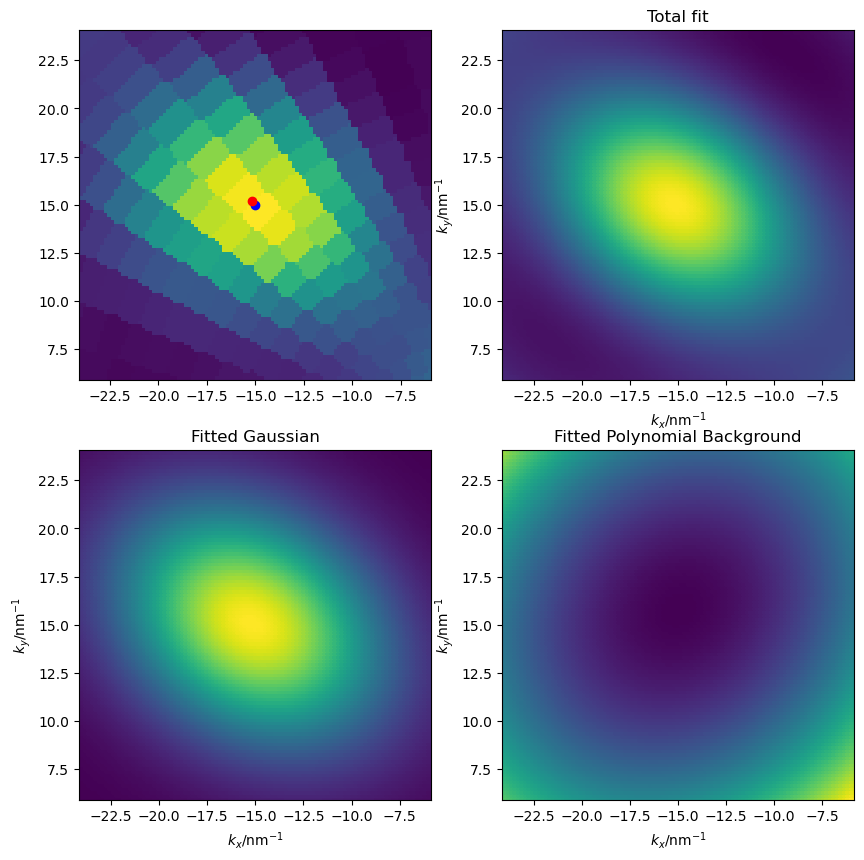

In [21]:
# loop over each peak and fit
found_ks = []
for i, ks in enumerate(guess_peak):
    if i != len(guess_peak) - 1:
        found_ks.append(find_diff_peak(d1, ks[0], ks[1], plotit=False, size=9, method='nearest'))
        if i > 5e5:
            break
fitted_param = np.array(found_ks)

In [22]:
kxs = fitted_param[:,1]
kys = fitted_param[:,2]
kxs = np.append(kxs, 0)
kys = np.append(kys, 0)
print(kxs)
print(kys)

[-53.2892284  -31.69224765 -10.39612046 -55.67543864 -33.68815979
 -13.05832735 -36.98137276 -15.14927382   0.        ]
[44.83646601 52.47398624 60.31542258 23.48378884 30.65756171 36.69039136
  9.83660222 15.1830596   0.        ]


In [27]:
dk_f = lambda x1, x2, y1, y2: np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
DK = [
    dk_f(kxs[0], kxs[1], kys[0], kys[1]),
    dk_f(kxs[0], kxs[3], kys[0], kys[3]),
    dk_f(kxs[0], kxs[4], kys[0], kys[4]),
    dk_f(kxs[1], kxs[2], kys[1], kys[2]),
    dk_f(kxs[1], kxs[4], kys[1], kys[4]),
    dk_f(kxs[1], kxs[5], kys[1], kys[5]),
    dk_f(kxs[2], kxs[5], kys[2], kys[5]),
    dk_f(kxs[3], kxs[4], kys[3], kys[4]),
    dk_f(kxs[3], kxs[6], kys[3], kys[6]),
    dk_f(kxs[4], kxs[5], kys[4], kys[5]),
    dk_f(kxs[4], kxs[6], kys[4], kys[6]),
    dk_f(kxs[4], kxs[7], kys[4], kys[7]),
    dk_f(kxs[5], kxs[7], kys[5], kys[7]),
    dk_f(kxs[6], kxs[7], kys[6], kys[7]),
    dk_f(kxs[7], kxs[8], kys[7], kys[8])
]
print(DK)
print('DK = {:.3f},\nstd = {:.3f},\nerror = {:.3f}'.format(np.mean(DK), np.std(DK), np.std(DK)/np.sqrt(9)))
a = 2*np.pi/np.mean(DK)/np.sqrt(3)*2
print('a = {:.4f} +/- {:.4f} pm'.format(a, a*0.021))

[np.float64(22.907668865240357), np.float64(21.485595676885865), np.float64(24.191800629575244), np.float64(22.69390131225971), np.float64(21.90753396670187), np.float64(24.420173074386117), np.float64(23.774554579968665), np.float64(23.12797976420879), np.float64(23.14549203752403), np.float64(21.493836801108568), np.float64(21.079791400699015), np.float64(24.14850945235119), np.float64(21.608733804043286), np.float64(22.477214030370167), np.float64(21.448211953990974)]
DK = 22.661,
std = 1.090,
error = 0.363
a = 0.3202 +/- 0.0067


## Final plot of found points

This plot displays the identified peak centres in red along with the initial guesses in blue, it goes in the supplementary information of the paper.

/tmp/ipykernel_14635/1694835044.py:10: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


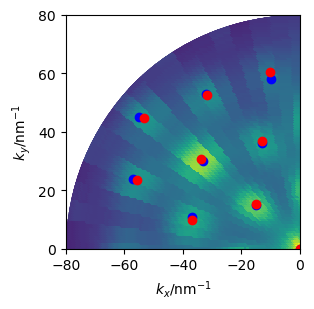

In [29]:
fig1, ax1, _  = d1.interpolated_plot(N=201,method='nearest')
for i, ks in enumerate(guess_peak):
    ax1.plot(ks[0],ks[1],'bo')
    ax1.plot(kxs[i],kys[i],'ro')
ax1.set_xlim(-80, 0)
ax1.set_ylim(0, 80)
ax1.set_yticks([0, 20, 40, 60, 80])
ax1.set_title(None)
fig1.set_size_inches(3.343, 3.343)
plt.tight_layout()
plt.savefig('figures_output/lattice_positions.pdf', dpi=450)